# Introduction.
The CIFAR-10 dataset contains 60,000 color images of 32 x 32 pixels in 3 channels divided into 10 classes. Each class contains 6,000 images. The training set contains 50,000 images, while the test sets provides 10,000 images. This image taken from the CIFAR repository ( https://www.cs.toronto.edu/~kriz/cifar.html ).

## Import And Preprocess Data 

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline

Using TensorFlow backend.


## Downloading DATA

In [2]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


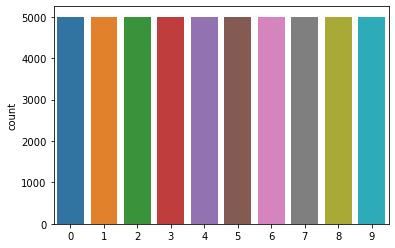

In [3]:
# Count plot for training set
sns.countplot(y_train.ravel())

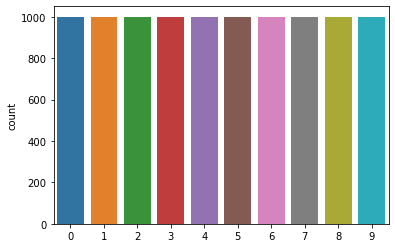

In [4]:
# Count plot for test set
sns.countplot(y_test.ravel())

In [5]:
# it is a numpy array
x_train

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

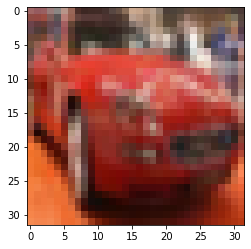

In [6]:
# using show to convert numpy array to image
plt.imshow(x_train[5])
plt.show()

In [7]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [8]:
# Normalize the data. Before we need to connvert data type to float for computation.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [9]:
# Convert class vectors to binary class matrices. This is called one hot encoding.
num_classes = 10  
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Trying 1st Model

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

# Keras defines a sequential model as a sequential stack of linear layers.
model=Sequential()

# here we using 32 filter layers and kernel size of (3,3), with relu activation function (max(0,x))
# Batch normalization() is a technique for improving the speed, performance, and stability of cnn.
# max pooling reduces the dimensionality of images by reducing the number of pixels in the output from previous cnn
# pool size define size of filter
# Droupout drops out the nodes from the layer and reduce chances of overfitting

#1st layer is input layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2nd layer
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3rd layer
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten convert matrix into single array
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Finally we compile our model with rsmprop optimizer
model.add(Dense(10,activation='softmax'))
model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)         

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#One way to avoid overfitting is to terminate the process early using earlystop
earlystop = EarlyStopping(patience = 10)

# Following line will reduce learning rate when a metric has stopped improving. 
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)

callbacks = [earlystop,learning_rate_reduction]

In [12]:

history = model.fit(x_train, y_train,
              batch_size=32,
              epochs=20,
              validation_data=(x_test, y_test),
              callbacks=callbacks,
                    shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 20s 408us/step - loss: 1.7134 - accuracy: 0.4271 - val_loss: 1.9887 - val_accuracy: 0.3795
Epoch 2/20
  608/50000 [..............................] - ETA: 13s - loss: 1.4084 - accuracy: 0.5148

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


50000/50000 [==============================] - 15s 309us/step - loss: 1.2298 - accuracy: 0.5678 - val_loss: 1.2204 - val_accuracy: 0.5780
Epoch 3/20
50000/50000 [==============================] - 15s 308us/step - loss: 1.1054 - accuracy: 0.6139 - val_loss: 1.0504 - val_accuracy: 0.6248
Epoch 4/20
50000/50000 [==============================] - 16s 330us/step - loss: 1.0192 - accuracy: 0.6444 - val_loss: 0.9477 - val_accuracy: 0.6675
Epoch 5/20
50000/50000 [==============================] - 16s 310us/step - loss: 0.9588 - accuracy: 0.6670 - val_loss: 1.5771 - val_accuracy: 0.5355
Epoch 6/20
50000/50000 [==============================] - 16s 314us/step - loss: 0.9204 - accuracy: 0.6811 - val_loss: 1.2589 - val_accuracy: 0.5810
Epoch 7/20
50000/50000 [==============================] - 15s 305us/step - loss: 0.8901 - accuracy: 0.6921 - val_loss: 1.1631 - val_accuracy: 0.6028
Epoch 8/20
50000/50000 [==============================] - 17s 338us/step - loss: 0.8601 - accuracy: 0.7042 - val_loss

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


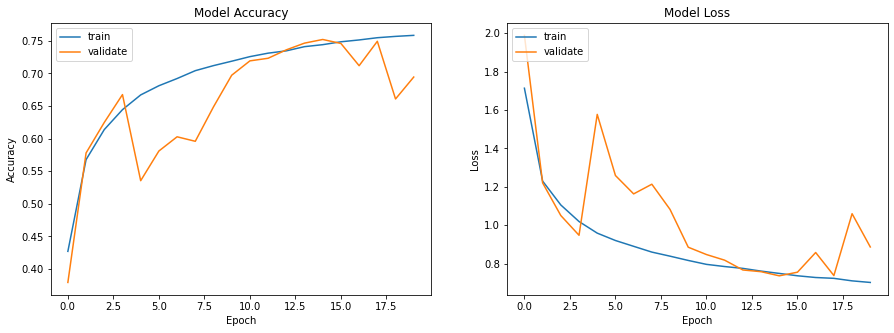

In [13]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)

## Trying 2nd Model

In [14]:
#define the convnet
model1 = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model1.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model1.add(Flatten())
model1.add(Dense(512))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
# a softmax classifier
model1.add(Dense(num_classes))
model1.add(Activation('softmax'))

opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
# Let's train the model using RMSprop
model1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 64)       

In [16]:
history1 = model1.fit(x_train, y_train,
              batch_size=32,
              epochs=20,
              validation_data=(x_test, y_test),
                      callbacks=callbacks,
                    shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 224us/step - loss: 0.9902 - accuracy: 0.6542 - val_loss: 0.9324 - val_accuracy: 0.6742
Epoch 2/20
50000/50000 [==============================] - 10s 210us/step - loss: 0.9550 - accuracy: 0.6678 - val_loss: 0.9206 - val_accuracy: 0.6743
Epoch 3/20
50000/50000 [==============================] - 11s 212us/step - loss: 0.9209 - accuracy: 0.6813 - val_loss: 0.9100 - val_accuracy: 0.6821
Epoch 4/20
50000/50000 [==============================] - 11s 214us/step - loss: 0.8938 - accuracy: 0.6879 - val_loss: 0.8587 - val_accuracy: 0.7000
Epoch 5/20
50000/50000 [==============================] - 10s 209us/step - loss: 0.8703 - accuracy: 0.6974 - val_loss: 0.8246 - val_accuracy: 0.7167
Epoch 6/20
50000/50000 [==============================] - 11s 229us/step - loss: 0.8484 - accuracy: 0.7078 - val_loss: 0.8190 - val_accuracy: 0.7226
Epoch 7/20
50000/50000 [==============================] 

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


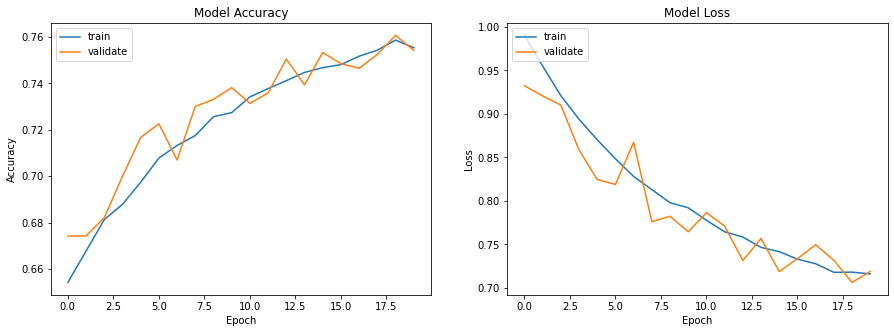

In [17]:
def plotmodelhistory(history1): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history1.history['accuracy']) 
    axs[0].plot(history1.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history1.history['loss']) 
    axs[1].plot(history1.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history1.history.keys())

plotmodelhistory(history1)

In [18]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test)

10000/10000 [==============================] - 1s 112us/step
Test loss: 0.8867084672927856
Test accuracy: 0.6944000124931335


In [19]:
# Score trained model.
scores = model1.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test)

10000/10000 [==============================] - 1s 94us/step
Test loss: 0.7190268657684327
Test accuracy: 0.7541999816894531


## We saw that our 2nd model with more parameters performs well on the given dataset. But for more better results use around 40-60 epoch.

## Viewing our result via images

In [20]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

In [21]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.92      0.47      0.62      1000
           1       0.97      0.65      0.77      1000
           2       0.82      0.40      0.53      1000
           3       0.51      0.67      0.58      1000
           4       0.47      0.88      0.61      1000
           5       0.74      0.57      0.65      1000
           6       0.65      0.90      0.75      1000
           7       0.85      0.73      0.79      1000
           8       0.83      0.81      0.82      1000
           9       0.75      0.87      0.81      1000

    accuracy                           0.69     10000
   macro avg       0.75      0.69      0.69     10000
weighted avg       0.75      0.69      0.69     10000



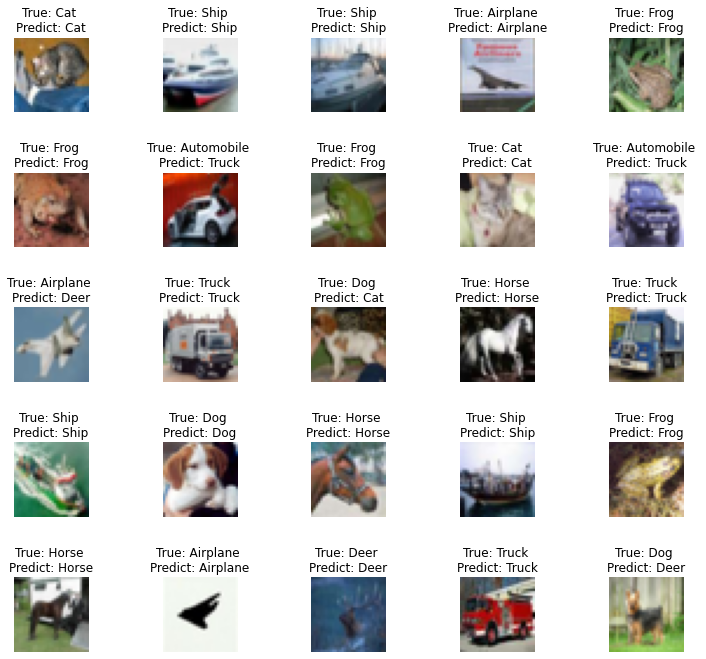

In [22]:
# viewing first 25 images with their actual and predicted values
R = 5    #row
C = 5    #col
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

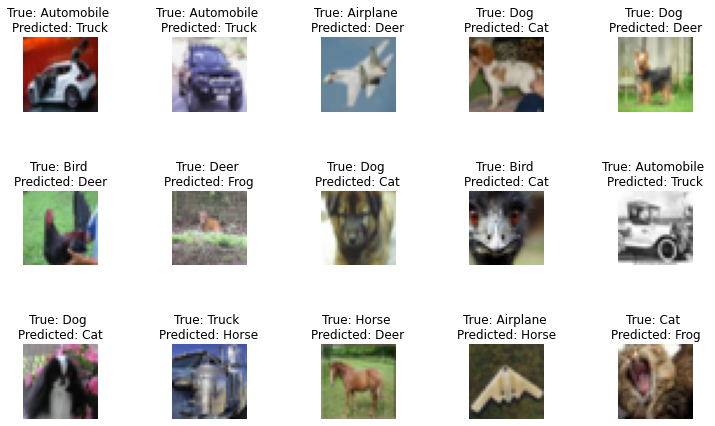

In [23]:
# viewing wrongly classified images
R = 3
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)